# Motion prediction

In [87]:
import numpy as np

class KalmanFilter:
    def __init__(self, observation, acceleration=False, measurement_noise=0.1, process_noise=0.001, dt=0.1):
        
        self.dims = 2

        ################################
        ### Kalman Filter Attributes ###
        ################################


        if acceleration:
            self.x = np.array([observation, [0., 0.], [0., 0.]]).flatten()
            self.P = np.vstack((
                                np.hstack((10*np.eye(self.dims), np.zeros((self.dims, 2*self.dims)))),
                                np.hstack((np.zeros((self.dims, self.dims)), 2*np.eye(self.dims), np.zeros((self.dims, self.dims)) )),
                                np.hstack((np.zeros((self.dims, 2*self.dims)), 1*np.eye(self.dims) )),
                                ))
            self.H = np.hstack((np.eye(self.dims), np.zeros((self.dims, 2*self.dims))))
            self.R = measurement_noise * np.eye(self.dims)
            self.F = np.vstack((
                                np.hstack((np.eye(self.dims), dt*np.eye(self.dims), (dt**2)/2*np.eye(self.dims))),
                                np.hstack((np.zeros((self.dims, self.dims)), np.eye(self.dims), dt*np.eye(self.dims))),
                                np.hstack((np.zeros((self.dims, 2 * self.dims)), np.eye(self.dims)))
                                ))
            self.Q = process_noise * np.eye(3*self.dims)

        else:
            self.x = np.array([observation, [0., 0.]]).flatten()
            self.P = np.vstack((
                                np.hstack((10*np.eye(self.dims), np.zeros((self.dims, self.dims)))),
                                np.hstack((np.zeros((self.dims, self.dims)), 2*np.eye(self.dims) )),
                                ))
            self.H = np.hstack((np.eye(self.dims), np.zeros((self.dims, self.dims))))
            self.F = np.vstack((
                                np.hstack((np.eye(self.dims), dt*np.eye(self.dims))),
                                np.hstack((np.zeros((self.dims, self.dims)), np.eye(self.dims))),
                                ))
            self.Q = process_noise * np.eye(2*self.dims)
            self.R = measurement_noise * np.eye(self.dims)



    def update(self, observation):

        ############################
        ### Kalman Filter Update ###
        ############################

        # calculate error or in KF terms 'y' --> difference between state and measurement
        z = observation
        err = z - np.matmul(self.H, self.x)
        # Get system uncertainty in measurement space
        S = np.matmul(np.matmul(self.H, self.P), self.H.transpose()) + self.R
        S_inv = np.linalg.inv(S)
        
        # Update Kalman gain
        K = np.matmul(np.matmul(self.P, self.H.transpose()), S_inv)
        # Update state with system cov
        self.x = self.x + np.matmul(K, err)
        self.P = np.matmul(np.eye(self.x.shape[0]) - np.matmul(K, self.H), self.P)

    def predict(self):

        #############################
        ### Kalman Filter Predict ###
        #############################

        self.x = np.matmul(self.F, self.x)
        self.P = np.matmul(np.matmul(self.F, self.P), self.F.transpose()) + self.Q

    def get_state(self):

        #########################
        ### Get Current State ###
        #########################
        return self.x

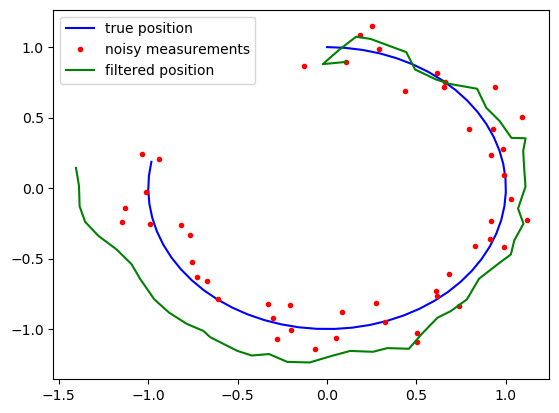

In [91]:
import matplotlib.pyplot as plt

# create Kalman filter instance
dt = 0.1
measurement_noise = 0.1
process_noise = 0.001

# simulate noisy measurements of a moving object
t = np.arange(0, 5, dt)

x_true = np.sin(t)
y_true = np.cos(t)

x_meas = x_true + np.random.randn(len(t)) * measurement_noise
y_meas = y_true + np.random.randn(len(t)) * measurement_noise

kf = KalmanFilter([x_true[0], y_true[0]], acceleration=True, process_noise=process_noise, measurement_noise=measurement_noise, dt=dt)


# run Kalman filter on measurements
x_filtered = np.zeros_like(x_meas)
y_filtered = np.zeros_like(y_meas)
for i in range(len(t)):
    kf.predict()
    kf.update(np.array([x_meas[i], y_meas[i]]))
    x_filtered[i], y_filtered[i] = kf.get_state()[0], kf.get_state()[1]

# plot results
plt.plot(x_true, y_true, 'b-', label='true position')
plt.plot(x_meas, y_meas, 'r.', label='noisy measurements')
plt.plot(x_filtered, y_filtered, 'g-', label='filtered position')
plt.legend()
plt.show()

